In [1]:
import sys
import os
import numpy as np
import pandas as pd
from qnorm import quantile_normalize


In [2]:
#Read targets

targets_strand_df = pd.read_csv('models/f0c0/testg-0/acc.txt', index_col=0, sep='\t')[['identifier', 'description']]


In [3]:
#Store original target indices

targets_strand_df['row_index'] = np.arange(len(targets_strand_df), dtype='int32')

#Get dataframe columns (identifiers)
cols = targets_strand_df['identifier'].values.tolist()


In [4]:

targets_strand_df


,identifier,description,row_index
34,ENCFF470BSF+,RNA:GM12878,0
36,ENCFF617ZDV+,RNA:GM12878,1
38,ENCFF993POP+,RNA:GM12878,2
40,ENCFF678ITA+,RNA:GM12878,3
42,ENCFF812WIL,RNA:GM12878,4
...,...,...,...
348,SRS4362911,RNA:ActD:HEK293T 293t_3h_chx_A,279
349,SRS4362912,RNA:ActD:HEK293T 293t_6h_ad_A,280
350,SRS4362913,RNA:ActD:HEK293T 293t_6h_chx_A,281
351,SRS4362914,RNA:ActD:HEK293T 293t_6h_ad_B,282


In [5]:
#Load gene dataframe

gene_df = pd.read_csv('models/f0c0/testg-0/genes.bed', sep='\t', names=['chrom', 'start', 'end', 'gene_id', 'feat1', 'strand'])[['chrom', 'gene_id', 'strand']].drop_duplicates(subset=['gene_id'], keep='first').copy().reset_index(drop=True)


In [6]:
#Load and augment measured / predicted coverages to gene dataframe

model_dirs = ['models', 'models_retry1', 'models_retry2']
fold_index = [0]

df = None

scores_pred = []
scores_true = []

#Loop over model directories (reps)
for model_dir in model_dirs :

    #Loop over folds
    for fold_ix in fold_index :

        #Load predictions
        df_pred = pd.read_csv("models/f" + str(fold_ix) + "c0/testg-0/gene_preds.tsv", sep='\t')
        df_pred = df_pred.rename(columns={'Unnamed: 0' : 'gene_id'})

        #Load targets
        df_true = pd.read_csv("models/f" + str(fold_ix) + "c0/testg-0/gene_targets.tsv", sep='\t')
        df_true = df_true.rename(columns={'Unnamed: 0' : 'gene_id'})

        scores_pred.append(np.array(df_pred.values[:, 1:], dtype='float32')[..., None])
        scores_true.append(np.array(df_true.values[:, 1:], dtype='float32')[..., None])
        
        if df is None :
            df = df_pred[['gene_id']].copy()

scores_pred = np.mean(np.concatenate(scores_pred, axis=-1), axis=-1)
scores_true = np.mean(np.concatenate(scores_true, axis=-1), axis=-1)

df['gene_base'] = df['gene_id'].apply(lambda x: x.split(".")[0])

print("len(df) = " + str(len(df)))
print("scores_pred.shape = " + str(scores_pred.shape))
print("scores_true.shape = " + str(scores_true.shape))


len(df) = 2470
scores_pred.shape = (2470, 284)
scores_true.shape = (2470, 284)


In [7]:
#Load and append HL measurements from Saluki paper

hl_df = pd.read_csv('../../half-life/all_HLs_human_PC1.txt', sep='\t')

print("len(hl_df) = " + str(len(hl_df)))

hl_dict = {}
for _, row in hl_df.iterrows() :
    hl_dict[row['ensembl_gene_id']] = row['human_PC1']

saluki_pc1 = []
for _, row in df.iterrows() :
    if row['gene_base'] in hl_dict :
        saluki_pc1.append(hl_dict[row['gene_base']])
    else :
        saluki_pc1.append(np.nan)

df['saluki_pc1'] = saluki_pc1


len(hl_df) = 13921


In [8]:
#Aggregate and store cell type-matched predictions

tissue_names = [
    'hek293',
    'k562',
    'hepg2',
    'gm12878',
    'jurkat',
    
    'jurkat_total',
    'jurkat_4su',
    
    'hela_actd_0h',
    'hela_actd_3h',
    'hela_actd_6h',
    
    'k562_actd_0h',
    'k562_actd_0.5h',
    'k562_actd_2h',
    'k562_actd_4h',
    'k562_actd_8h',
    
    'hues9_actd_0h',
    'hues9_actd_0.5h',
    'hues9_actd_2h',
    'hues9_actd_4h',
    'hues9_actd_8h',
    
    'hek293_4su_1h',
    'hek293_4su_2h',
    'hek293_4su_4h',
    'hek293_4su_8h',
    'hek293_4su_12h',
    'hek293_4su_24h',
    'hek293_4su_SS',
    
    'hek293_actd_nt',
    'hek293_actd_actd',
    
    'hek293t_act_0h',
    'hek293t_act_1h_ad',
    'hek293t_act_3h_ad',
    'hek293t_act_6h_ad',
    
    'lcl_total',
    'lcl_4su_30',
    'lcl_4su_60',
]

tissues_regexps = [
    'RNA:4sU:HEK293 total RNA|RNA:ActD:HEK293T Control for DCP2 knockout|RNA:ActD:HEK293T half-life measurement by transcriptional inhibition ctrl_nt_|RNA:4sU:HEK293_SS_R1|RNA:ActD:HEK293T 293t_0h_',
    'RNA:K562$',
    'RNA:HepG2$',
    'RNA:GM12878$',
    'RNA:Jurkat, Clone E6-1$',
    
    'RNA:4sU:Jurkat total RNA',
    'RNA:4sU:Jurkat 4sU-labeled RNA',
    
    'RNA:ActD:HeLa mRNA lifetime-SiControl-TI-0h D1',
    'RNA:ActD:HeLa mRNA lifetime-SiControl-TI-3h D2',
    'RNA:ActD:HeLa mRNA lifetime-SiControl-TI-6h D3',
    
    'RNA:ActD:K562__0\.0h__rep.',
    'RNA:ActD:K562__0\.5h__rep.',
    'RNA:ActD:K562__2h__rep.',
    'RNA:ActD:K562__4h__rep.',
    'RNA:ActD:K562__8h__rep.',
    
    'RNA:ActD:HUES9__0\.0h__rep.',
    'RNA:ActD:HUES9__0\.5h__rep.',
    'RNA:ActD:HUES9__2h__rep.',
    'RNA:ActD:HUES9__4h__rep.',
    'RNA:ActD:HUES9__8h__rep.',
    
    'RNA:4sU:HEK293_1h_R1',
    'RNA:4sU:HEK293_2h_R1',
    'RNA:4sU:HEK293_4h_R1',
    'RNA:4sU:HEK293_8h_R1',
    'RNA:4sU:HEK293_12h_R1',
    'RNA:4sU:HEK293_24h_R1',
    'RNA:4sU:HEK293_SS_R1',
    
    'RNA:ActD:HEK293T half-life measurement by transcriptional inhibition ctrl_nt_.*',
    'RNA:ActD:HEK293T half-life measurement by transcriptional inhibition ctrl_actD_.*',
    
    'RNA:ActD:HEK293T 293t_0h_.*',
    'RNA:ActD:HEK293T 293t_1h_ad_.*',
    'RNA:ActD:HEK293T 293t_3h_ad_.*',
    'RNA:ActD:HEK293T 293t_6h_ad_.*',
    
    'RNA:HapMap LCL RNA-seq of YRI individual.*',
    'RNA:4sU:HapMap LCL 4sU-seq of YRI individual.*-30-.*',
    'RNA:4sU:HapMap LCL 4sU-seq of YRI individual.*-60-.*',
]

for tissue_name, filter_query in zip(tissue_names, tissues_regexps) :

    target_index = targets_strand_df.loc[targets_strand_df['description'].str.contains(filter_query)]['row_index'].values.tolist()

    df['borzoi_' + tissue_name] = np.mean(scores_pred[:, target_index], axis=-1)
    df = df.copy()


In [9]:
#Fit regression model to Saluki PC1 measurements

from sklearn.linear_model import Ridge

df_sub = df.loc[~df['saluki_pc1'].isnull()].copy()

pred_vals = df_sub[[
    'borzoi_hek293',
    'borzoi_k562',
    'borzoi_hepg2',
    'borzoi_gm12878',
    'borzoi_jurkat',
    
    'borzoi_jurkat_total',
    'borzoi_jurkat_4su',
    
    'borzoi_hela_actd_0h',
    'borzoi_hela_actd_3h',
    'borzoi_hela_actd_6h',
    
    'borzoi_k562_actd_0h',
    'borzoi_k562_actd_0.5h',
    'borzoi_k562_actd_2h',
    'borzoi_k562_actd_4h',
    'borzoi_k562_actd_8h',
    
    'borzoi_hues9_actd_0h',
    'borzoi_hues9_actd_0.5h',
    'borzoi_hues9_actd_2h',
    'borzoi_hues9_actd_4h',
    'borzoi_hues9_actd_8h',
    
    'borzoi_hek293_4su_1h',
    'borzoi_hek293_4su_2h',
    'borzoi_hek293_4su_4h',
    'borzoi_hek293_4su_8h',
    'borzoi_hek293_4su_12h',
    'borzoi_hek293_4su_24h',
    'borzoi_hek293_4su_SS',
    
    'borzoi_hek293_actd_nt',
    'borzoi_hek293_actd_actd',
    
    'borzoi_hek293t_act_0h',
    'borzoi_hek293t_act_1h_ad',
    'borzoi_hek293t_act_3h_ad',
    'borzoi_hek293t_act_6h_ad',
    
    'borzoi_lcl_total',
    'borzoi_lcl_4su_30',
    'borzoi_lcl_4su_60',
]].values.copy()

meas = df_sub['saluki_pc1'].values

lr = Ridge(alpha=0.1)
_ = lr.fit(pred_vals, meas)

meas_pred = lr.predict(pred_vals)

print("lr.coef_ = " + str(lr.coef_))


lr.coef_ = [ 3.7148118   0.17973696 -0.09390904  0.5866788  -0.25602955  0.83467996
 -0.38345236  0.63695276 -3.379302    2.6270087  -1.8928508  -0.21441361
  1.7365259  -1.5812799   2.0024061   1.0153722  -1.3637915   0.01016796
  0.72792304 -0.0252919   2.6747928  -6.5135703  -1.7075957   4.8367705
  1.904688   -1.2827611  -0.94915324 -0.17384326 -0.705797   -1.9290179
 -4.707601    8.4724     -4.0555463   0.18025155  3.6172004  -4.3706493 ]


1744
SpearmanrResult(correlation=0.7548400450549074, pvalue=2.213e-321)
PearsonRResult(statistic=0.7698374465000752, pvalue=0.0)


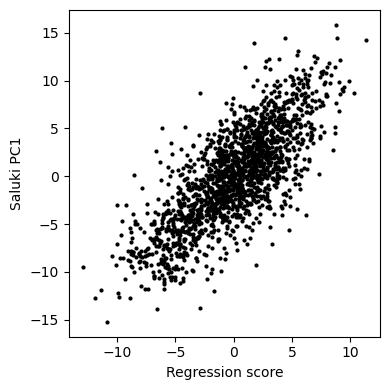

In [10]:
from scipy.stats import spearmanr, pearsonr
import matplotlib.pyplot as plt

print(len(df_sub))
print(spearmanr(meas_pred, df_sub['saluki_pc1'].values))
print(pearsonr(meas_pred, df_sub['saluki_pc1'].values))

f = plt.figure(figsize=(4, 4))

plt.scatter(meas_pred, df_sub['saluki_pc1'].values, color='black', s=4)

plt.xlabel("Regression score")
plt.ylabel("Saluki PC1")

plt.tight_layout()

plt.show()


In [11]:
#Store models

import pickle

pickle.dump({'lr' : lr}, open('lr_saluki_pc1_f0.pkl', 'wb'))
